![Course title](./images/title.png)
<i> Alexey Bochkarev </i> | [🌐 www.bochkarev.io](https://www.bochkarev.io) | [✉ a@bochkarev.io](mailto:a@bochkarev.io)

**Discord:** `co05-как-учить-машины-простые-примеры-про-ml`

# ③ Neural Networks!

Let's make some really hard-to-describe data now.

In [461]:
# data generation
import numpy as np
import pandas as pd

X = []; Y = []
for k in range(500):
    x1 = np.random.rand()*100.0
    x2 = np.random.rand()*100.0
    if ((x1 > 50) or (x2>50)) and not ((x1>50) and (x2>50)):
        y = 1
    else:
        y =  0
        
    X.append([x1,x2])
    Y.append(y)
    
df = pd.DataFrame({'x1':[x[0] for x in X], 'x2':[x[1] for x in X], 'y':Y})
df.head(10)

,x1,x2,y
0,52.431797,0.306629,1
1,56.748718,22.745992,1
2,24.228439,95.364811,1
3,46.839884,34.502843,0
4,74.859756,27.415606,1
5,13.446404,3.583176,0
6,45.358244,85.372819,1
7,19.342733,7.944035,0
8,65.214175,43.807840,1
9,30.918485,35.834819,0


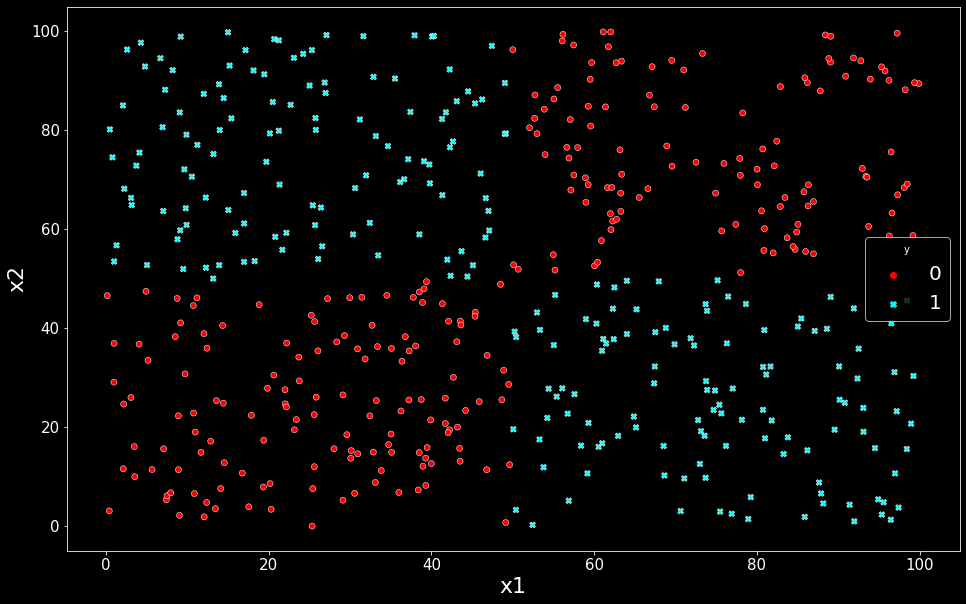

In [462]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("dark_background"); plt.rc('legend',fontsize=20)
plt.figure(figsize=(16, 10))

sns.scatterplot(data=df, x="x1", y="x2", hue="y", style="y",
                palette=["red", "cyan"]);
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel("x1", fontsize=22); plt.ylabel("x2", fontsize=22)
plt.show()

## Baseline: quick-and-simple logit

In [463]:
# Okay, baseline
import statsmodels.api as sm

model = sm.Logit(df['y'], sm.add_constant(df[["x1", "x2"]])).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.691301
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  500
Model:                          Logit   Df Residuals:                      497
Method:                           MLE   Df Model:                            2
Date:                Sat, 09 Jul 2022   Pseudo R-squ.:                0.001511
Time:                        22:40:27   Log-Likelihood:                -345.65
converged:                       True   LL-Null:                       -346.17
Covariance Type:            nonrobust   LLR p-value:                    0.5926
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2681      0.234     -1.146      0.252      -0.727       0.190
x1             0.0007      0.

In [465]:
df['baseline_pred_prob'] = model.predict(sm.add_constant(df[["x1", "x2"]]))

threshold = 0.5
df['baseline_pred'] = df['baseline_pred_prob'] >= 0.5

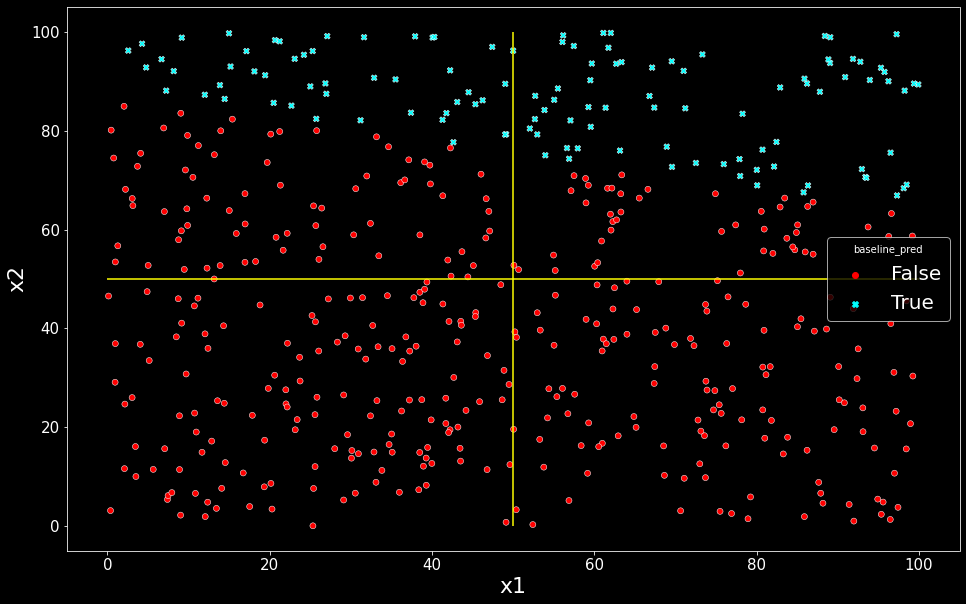

In [466]:
plt.figure(figsize=(16, 10))
sns.scatterplot(data=df, x="x1", y="x2", hue="baseline_pred", style="baseline_pred",
               palette=["red", "cyan"]);
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel("x1", fontsize=22); plt.ylabel("x2", fontsize=22)
plt.hlines(xmin=0, xmax=100, y=[50], color='yellow')
plt.vlines(ymin=0, ymax=100, x=[50], color='yellow')
plt.show()

## We obviously need something better.

Hmmm... What if we stacked a few `logit`s together?..

### A "preceptron"

<div>
<img src="images/neuron.png" width="1000"/>
</div>


### ... aaand we can have a few of those:

<div>
<img src="images/NN.png" width="1000"/>
</div>

## How to use it?

1. How to **predict** is relatively clear, right?
*(Blackboard: forward pass)*

2. But how to **learn**?
*(Blackboard: backward pass)*

In [548]:
from math import exp

def sigmoid(t):
    """Implements the sigmoid function."""
    return 1/(1+exp(-t))


def sprime(t):
    """Calculates the first derivative of the sigmoid."""
    return 1/(exp(-t)+exp(t)+2)

### Ok, let's implement the forward pass:

In [559]:
def forward(W0, W, x1, x2):
    h = [sigmoid(np.dot(W[j], [1, x1, x2]))
                       for j in range(len(W))]
    
    out = sigmoid(np.dot(W0, [1] + h))
    
    return out, h

def forward_batch(W0, W, x_batch):
    """Calculates predicted y-s for a batch of points."""
    return [forward(W0, W, x[0], x[1]) for x in x_batch]

### Then, the loss:

In [550]:
def batch_loss(y_batch, fwd_batch):
    """Calculates loss for a batch of points."""
    return np.sum([(y_batch[i] - fwd_batch[i][0])**2 for i in range(len(y_batch))])

### ... and the *backpropagation* of errors:

In [556]:
def update_weight(W0, W, fwd_pass_batch, y_batch, x_batch, gamma=0.01):
    """Returns a weight increment."""
    # weight increments
    dW = [np.array([0.0, 0.0, 0.0]) for _ in range(len(W))]
    dW0 = np.array([0.0 for _ in range(len(W0))])
    
    for j in range(len(y_batch)):
        x1, x2 = x_batch[j]
        y_pred, h = fwd_pass_batch[j]
        y = y_batch[j]
        
        # update the out-layer weights
        dW0 -= gamma * 2 * (y_pred - y) * sprime(np.dot(W0, [1] + h)) * np.array(
            [1] + h)
        
        # update the hidden layer weights
        for s in range(len(W)):
            dW[s] -=  gamma * 2 * (y_pred - y) * sprime(np.dot(W0, [1] + h)
                                                   ) * sprime(np.dot(W[s], [1, x1, x2])
                                                             ) * np.array([
                        1,
                        x1,
                        x2])
            
    return np.array(dW), dW0

### Now, *train* the whole thing:

In [561]:
def train(X, Y, W0_start, W_start, NO_EPOCHS=100, NO_BATCHES=10):
    W = W_start
    W0 = W0_start
    
    losses = []
    NpB = len(Y) // NO_BATCHES
    
    for epoch in range(NO_EPOCHS):
        loss = 0.0
        for b in range(NO_BATCHES):
            x_batch = X[b*NpB:(b+1)*NpB]
            y_batch = Y[b*NpB:(b+1)*NpB].values.tolist()
        
            fwd_batch = forward_batch(W0, W, x_batch)
            
            loss += batch_loss(y_batch, fwd_batch)
            
            dW, dW0 = update_weight(W0, W, fwd_batch, y_batch, x_batch, gamma = 0.01)
            W += dW
            W0 += dW0
        
        losses.append(loss)
        
    return W, losses

## Let the magic begin!

In [622]:
from time import time
N_hidden = 2

t0 = time()
W = [[(np.random.rand()-0.5) for _ in range(3)] for _ in range(N_hidden)]
W0 = np.array([np.random.rand() - 0.5 for _ in range(N_hidden+1)])
W, losses = train(df[['x1','x2']].values.tolist(), df['y'], W0, W, 40000)
t1 = time()
print(f"Learning finished in {(t1-t0):.1f} sec.")

Learning finished in 745.0 sec.


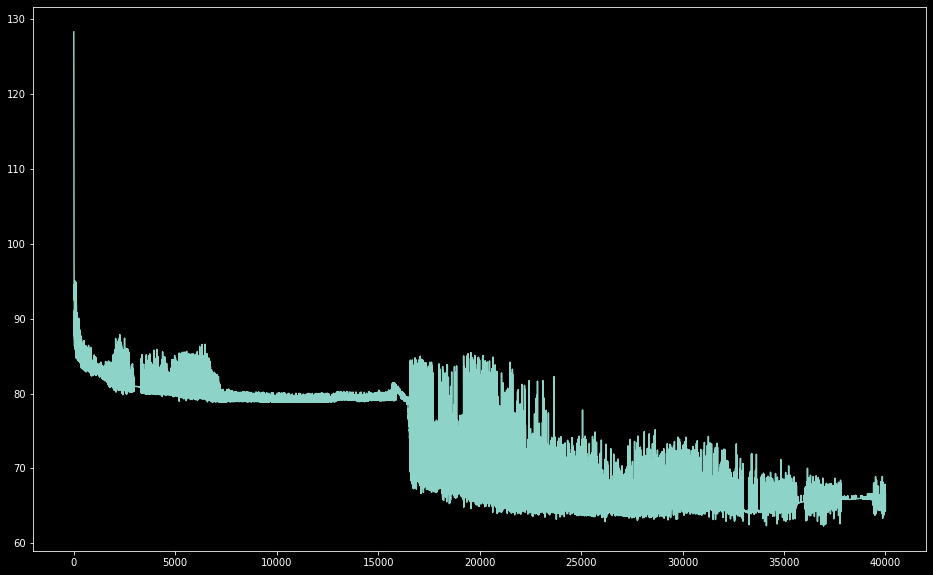

In [623]:
plt.figure(figsize=(16, 10))
plt.plot([j for j in range(len(losses))], losses)

In [624]:
df['DN_pred_prob'] = [forward(W0, W, df['x1'][i], df['x2'][i])[0] for i in range(len(df))]
df['DN_pred_prob'].head(10)

0    0.916508
1    0.543076
2    0.833807
3    0.171204
4    0.916500
5    0.171204
6    0.833795
7    0.171204
8    0.171204
9    0.171204
Name: DN_pred_prob, dtype: float64

In [625]:
df['DN_pred'] = df['DN_pred_prob'] >= 0.5
df['DN_pred'].head(10)

0     True
1     True
2     True
3    False
4     True
5    False
6     True
7    False
8    False
9    False
Name: DN_pred, dtype: bool

In [626]:
sum(df['DN_pred'])

215

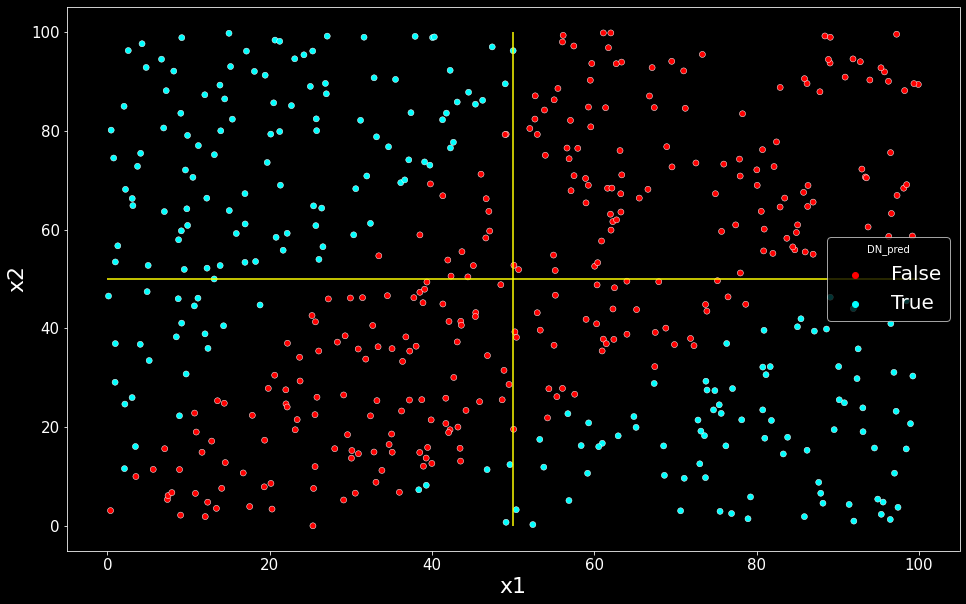

In [627]:
plt.figure(figsize=(16, 10))
sns.scatterplot(data=df, x="x1", y="x2", hue="DN_pred",
               palette=['red', 'cyan']);
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel("x1", fontsize=22); plt.ylabel("x2", fontsize=22)
plt.hlines(xmin=0, xmax=100, y=[50], color='yellow')
plt.vlines(ymin=0, ymax=100, x=[50], color='yellow')
plt.show()

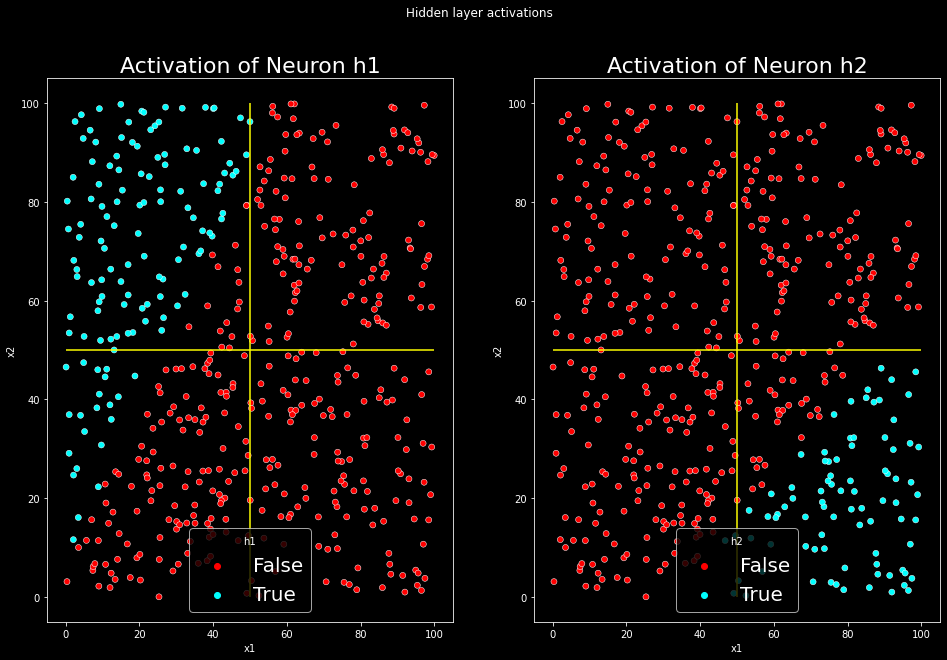

In [632]:
fwd_pass = [forward(W0, W, df['x1'][i], df['x2'][i]) for i in range(len(df))]

for h in range(1, N_hidden + 1):
    df[f"h{h}"] = [fwd_pass[i][1][h-1] >= 0.5 for i in range(len(df))]

fig, ax = plt.subplots(1, N_hidden, figsize=(16,10))
fig.suptitle('Hidden layer activations')

for h in range(1, N_hidden + 1):
    sns.scatterplot(data=df, x="x1", y="x2", hue=f"h{h}",ax=ax[h-1],
                   palette=['red', 'cyan']);
    ax[h-1].hlines(xmin=0, xmax=100, y=[50], color='yellow')
    ax[h-1].vlines(ymin=0, ymax=100, x=[50], color='yellow')
    ax[h-1].set_title(f"Activation of Neuron h{h}", fontsize=22)

In [1]:
fwd_pass = [forward(W0, W, df['x1'][i], df['x2'][i]) for i in range(len(df))]

for h in range(1, N_hidden + 1):
    df[f"h{h}_prob"] = [fwd_pass[i][1][h-1] for i in range(len(df))]
    
sns.scatterplot(data=df, x="h1_prob", y="h2_prob", hue=f"DN_pred",ax=ax[h-1],
                palette=['red', 'cyan']);

NameError: name 'df' is not defined

# Optional topic: Let's make a *DEEP* NN now

In [637]:
def DN_forward(W, V, F, x1, x2):
    h = [sigmoid(np.dot(W[j], [1, x1, x2]))
         for j in range(len(W))]
    d = [sigmoid(np.dot(V[j], [1] + h))
         for j in range(len(V))]
    out = sigmoid(np.dot(F, [1] + d))
    
    return out, h, d

def DN_forward_batch(W, V, F, x_batch):
    """Calculates predicted y-s for a batch of points."""
    return [DN_forward(W, V, F, x[0], x[1]) for x in x_batch]

In [641]:
def DN_update_weight(W, V, F, fwd_pass_batch, y_batch, x_batch, gamma=0.01):
    """Returns a weight increment."""
    # weight increments
    dW = [np.array([0.0, 0.0, 0.0]) for _ in range(2)]
    dV = [np.array([0.0, 0.0, 0.0]) for _ in range(2)]
    dF = np.array([0.0, 0.0, 0.0])
    
    for j in range(len(y_batch)):
        x1, x2 = x_batch[j]
        y_pred, h, d = fwd_pass_batch[j]
        y = y_batch[j]
        
        # update the out-layer weights
        dF -= gamma * 2 * (y_pred - y) * sprime(np.dot(F, [1] + d)) * np.array(
            [1] + d)
        
        # update the second hidden ('deep') layer weights
        for s in range(len(V)):
            dV[s] -=  gamma * 2 * (y_pred - y) * sprime(np.dot(F, [1] + d)
                                            ) * sprime(np.dot(V[s], [1] + h)
                                            ) * F[s+1] * np.array([1] + h)
        
        # update the first hidden layer weights
        for s in range(len(W)):
            dW[s] -= gamma * 2 * (y_pred - y) * sprime(np.dot(F, [1] +d)
                                            ) * (F[1]*sprime(np.dot(V[0], [1]+h)) + (
                                                 F[2]*sprime(np.dot(V[1], [1]+h)))) * sprime(
                                            np.dot(W[s], [1, x1, x2])) * np.array([1, x1, x2])
           
            
    return np.array(dW),np.array(dV), np.array(dF)

In [639]:
def DN_train(X, Y, W_start, V_start, F_start, NO_EPOCHS=100, NO_BATCHES=10):
    W = W_start
    V = V_start
    F = F_start
    
    losses = []
    NpB = len(Y) // NO_BATCHES
    
    for epoch in range(NO_EPOCHS):
        loss = 0.0
        for b in range(NO_BATCHES):
            x_batch = X[b*NpB:(b+1)*NpB]
            y_batch = Y[b*NpB:(b+1)*NpB].values.tolist()
        
            fwd_batch = DN_forward_batch(W, V, F, x_batch)
            
            loss += batch_loss(y_batch, fwd_batch)
            
            dW, dV, dF = DN_update_weight(W, V, F, fwd_batch, y_batch, x_batch, gamma = 0.01)
            W += dW
            V += dV
            F += dF
        
        losses.append(loss)
        
    return W, V, F, losses

In [665]:
t0 = time()
W = [[(np.random.rand()-0.5) for _ in range(3)] for _ in range(2)]
V = [[(np.random.rand()-0.5) for _ in range(3)] for _ in range(2)]
F = [np.random.rand()-0.5 for _ in range(3)]

W, V, F, losses = DN_train(df[['x1','x2']].values.tolist(), df['y'], W,V,F, 100000)
t1 = time()
print(f"Learning finished in {(t1-t0):.1f} sec.")

Learning finished in 3903.7 sec.


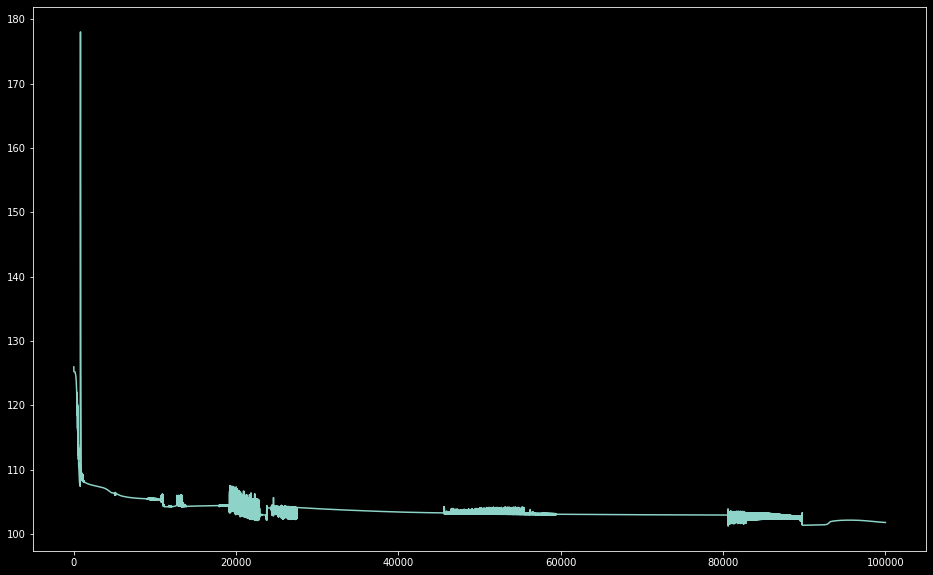

In [666]:
plt.figure(figsize=(16, 10))
plt.plot([j for j in range(len(losses))], losses)

In [667]:
df['DNN_pred_prob'] = [DN_forward(W, V, F, df['x1'][i], df['x2'][i])[0] for i in range(len(df))]
df['DNN_pred_prob'].head(10)

0    0.372860
1    0.372860
2    0.929181
3    0.372860
4    0.372860
5    0.372860
6    0.919989
7    0.372860
8    0.372860
9    0.372860
Name: DNN_pred_prob, dtype: float64

In [668]:
df['DNN_pred'] = df['DNN_pred_prob'] >= 0.5
sum(df['DNN_pred'])

119

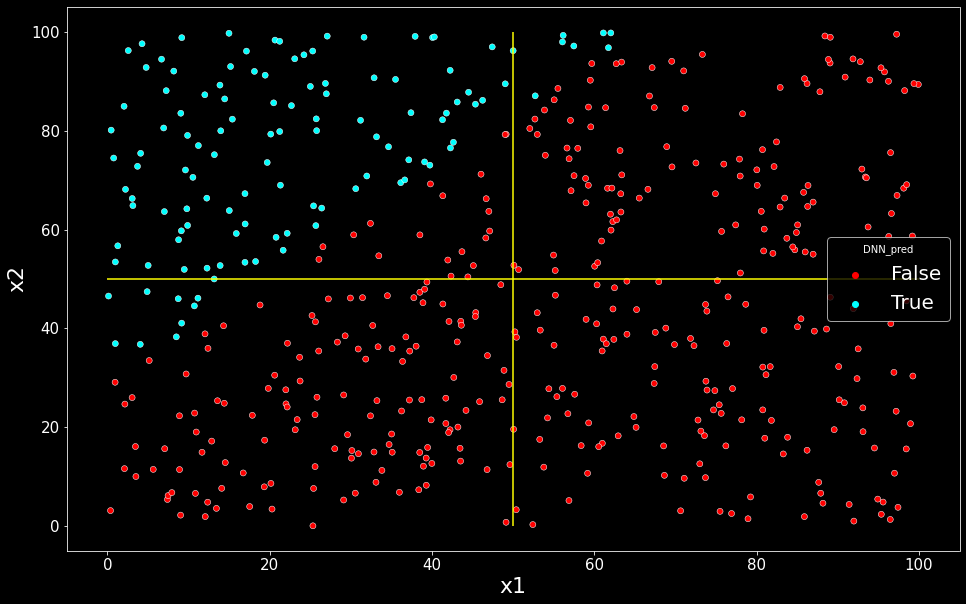

In [669]:
plt.figure(figsize=(16, 10))
sns.scatterplot(data=df, x="x1", y="x2", hue="DNN_pred",
               palette=['red', 'cyan']);
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel("x1", fontsize=22); plt.ylabel("x2", fontsize=22)
plt.hlines(xmin=0, xmax=100, y=[50], color='yellow')
plt.vlines(ymin=0, ymax=100, x=[50], color='yellow')
plt.show()